# Cloud Faculty Institute Workshop: Predict Diabetes from Medical Records

## Overview
This project involves participating in a Kaggle competition aimed at predicting diabetes based on medical records. The dataset is derived from the National Institute of Diabetes and Digestive and Kidney Diseases, with the goal of diagnostically predicting whether a patient has diabetes based on specific diagnostic measurements.

## Dataset Description

### Context
The dataset consists of medical records from female patients who are at least 21 years old and of Pima Indian heritage. The primary objective is to predict the onset of diabetes using various medical predictor variables.

### Content
The dataset includes several predictor variables and one target variable, `Outcome`. The predictor variables include:
- `Pregnancies`: Number of pregnancies the patient has had
- `Glucose`: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- `BloodPressure`: Diastolic blood pressure (mm Hg)
- `SkinThickness`: Triceps skin fold thickness (mm)
- `Insulin`: 2-Hour serum insulin (mu U/ml)
- `BMI`: Body mass index (weight in kg/(height in m)^2)
- `DiabetesPedigreeFunction`: Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)
- `Age`: Age (years)
- `Outcome`: Class variable (0 or 1) indicating whether the patient has diabetes (1) or not (0)

### Files
- `train.csv`: The training dataset containing the predictor variables and the target variable.
- `test.csv`: The test dataset containing the predictor variables but not the target variable.
- `sample_submission.csv`: A sample submission file in the correct format for predictions.

## Acknowledgements
The dataset was referenced from:
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## Objective
The challenge is to build a machine learning model that can accurately predict whether or not the patients in the test dataset have diabetes. This involves exploring the data, preprocessing it, selecting appropriate models, and fine-tuning them to achieve the best performance.

In [24]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Id
0,6,148,72,35,0,33.6,0.627,50,1,0
1,1,85,66,29,0,26.6,0.351,31,0,1
2,1,89,66,23,94,28.1,0.167,21,0,3
3,0,137,40,35,168,43.1,2.288,33,1,4
4,5,116,74,0,0,25.6,0.201,30,0,5


In [3]:
# Do we need to input any missing data?
train.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Id                          0
dtype: int64

BMI Statistics:
count    561.000000
mean      31.845633
std        7.798122
min        0.000000
25%       27.300000
50%       32.000000
75%       36.500000
max       67.100000
Name: BMI, dtype: float64


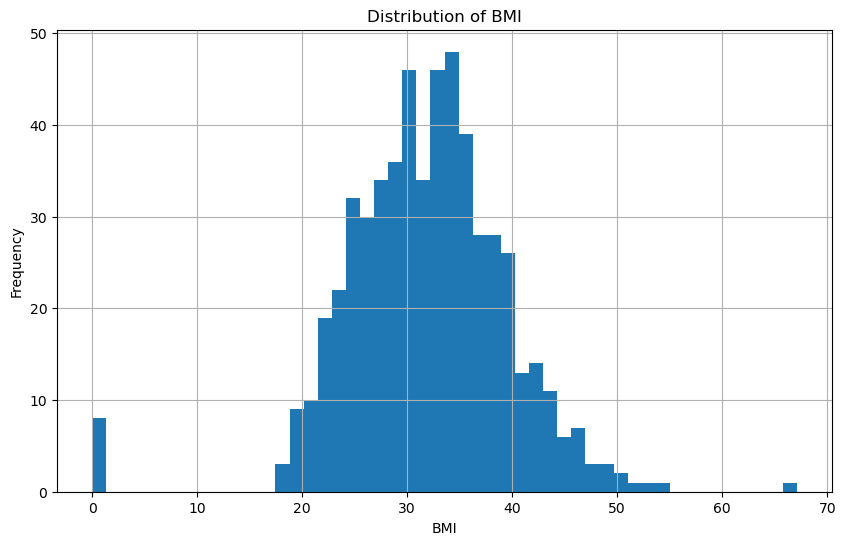

In [4]:
# Basic statistics of BMI
print("BMI Statistics:")
print(train['BMI'].describe())

# Visualize the distribution

plt.figure(figsize=(10, 6))
train['BMI'].hist(bins=50)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()


In [5]:
# List of numeric columns (excluding 'Outcome' and 'Id')
numeric_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for column in numeric_columns:
    print(f"\nAnalysis of {column}:")
    print(train[column].describe())

# Check for zero values in each column
zero_counts = (train[numeric_columns] == 0).sum()
print("\nCount of zero values in each column:")
print(zero_counts)


Analysis of Pregnancies:
count    561.000000
mean       3.939394
std        3.328969
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       15.000000
Name: Pregnancies, dtype: float64

Analysis of Glucose:
count    561.000000
mean     121.399287
std       32.121270
min        0.000000
25%       99.000000
50%      118.000000
75%      141.000000
max      199.000000
Name: Glucose, dtype: float64

Analysis of BloodPressure:
count    561.000000
mean      68.832442
std       19.732146
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

Analysis of SkinThickness:
count    561.000000
mean      20.889483
std       16.189015
min        0.000000
25%        0.000000
50%       23.000000
75%       33.000000
max       99.000000
Name: SkinThickness, dtype: float64

Analysis of Insulin:
count    561.000000
mean      77.217469
std      107.642011
min        0.000000
25%        0.00000

In [6]:
def clean_data(df):
    # Copy the dataframe to avoid modifying the original
    cleaned_df = df.copy()
    
    # Glucose
    cleaned_df['Glucose'] = cleaned_df['Glucose'].replace(0, cleaned_df['Glucose'].median())
    
    # BloodPressure
    cleaned_df['BloodPressure'] = cleaned_df['BloodPressure'].replace(0, cleaned_df['BloodPressure'].median())
    
    # SkinThickness
    skin_median = cleaned_df['SkinThickness'][cleaned_df['SkinThickness'] != 0].median()
    cleaned_df['SkinThickness'] = cleaned_df['SkinThickness'].replace(0, skin_median)
    
    # Insulin
    cleaned_df['Insulin_Measured'] = (cleaned_df['Insulin'] != 0).astype(int)
    insulin_median = cleaned_df['Insulin'][cleaned_df['Insulin'] != 0].median()
    cleaned_df['Insulin'] = cleaned_df['Insulin'].replace(0, insulin_median)
    cleaned_df['Insulin_Log'] = np.log1p(cleaned_df['Insulin'])
    
    # BMI
    cleaned_df = cleaned_df[cleaned_df['BMI'] >= 10]
    
    return cleaned_df

# Apply cleaning
cleaned_train = clean_data(train)

# Print summary of changes
print(f"Original dataset size: {len(train)}")
print(f"Cleaned dataset size: {len(cleaned_train)}")
print(f"Removed {len(train) - len(cleaned_train)} entries")

# Recheck statistics for all columns
for column in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Insulin_Log']:
    print(f"\nUpdated statistics for {column}:")
    print(cleaned_train[column].describe())

Original dataset size: 561
Cleaned dataset size: 553
Removed 8 entries

Updated statistics for Pregnancies:
count    553.000000
mean       3.924051
std        3.328296
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       15.000000
Name: Pregnancies, dtype: float64

Updated statistics for Glucose:
count    553.000000
mean     122.462929
std       30.504558
min       56.000000
25%       99.000000
50%      118.000000
75%      141.000000
max      199.000000
Name: Glucose, dtype: float64

Updated statistics for BloodPressure:
count    553.000000
mean      72.235081
std       12.261156
min       24.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

Updated statistics for SkinThickness:
count    553.000000
mean      29.667269
std        9.091003
min        7.000000
25%       25.000000
50%       30.000000
75%       33.000000
max       99.000000
Name: SkinThickness, dtype: float64

Upda

## Data Preprocessing and Model Training

In this section, we will perform several key steps to prepare the data and train our first machine learning model, a K-Nearest Neighbors (KNN) classifier. The following steps are included:

1. **Dropping Unnecessary Columns**:
   - We will drop the `Id` column from the training dataset as it does not provide any useful information for predicting diabetes.

2. **Data Splitting**:
   - We will split the training data into training and testing sets. This helps us to evaluate the model on unseen data and get an estimate of its performance.
   - We use `train_test_split` with stratification to ensure that the distribution of the target variable (`Outcome`) is the same in both the training and testing sets.

3. **Feature Normalization**:
   - We will normalize the feature values using `StandardScaler`. Normalization scales the features to have zero mean and unit variance, which is important for distance-based algorithms like KNN.

4. **Training the KNN Model**:
   - We will initialize and train a K-Nearest Neighbors classifier with `n_neighbors=5`.
   - The model will be trained on the normalized training data.

5. **Model Evaluation**:
   - We will evaluate the model's performance on the test set by calculating its accuracy.
   - Additionally, we will print the confusion matrix and classification report to get a detailed understanding of the model's performance in terms of precision, recall, and F1-score.


In [7]:
# Data Preprocessing
X = cleaned_train.drop(columns=['Id', 'Outcome'])
y = cleaned_train['Outcome']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

# KNN Model
knn = KNN(n_neighbors=5)
knn.fit(X_train, y_train)


# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

print("KNN Model Evaluation:")
evaluate_model(knn, X_train, X_test, y_train, y_test)

KNN Model Evaluation:
Accuracy: 0.762589928057554
Confusion Matrix:
 [[76 13]
 [20 30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82        89
           1       0.70      0.60      0.65        50

    accuracy                           0.76       139
   macro avg       0.74      0.73      0.73       139
weighted avg       0.76      0.76      0.76       139



### Interpretation of Results

1. **Overall Accuracy**: The model correctly predicted diabetes status for 76.25% of the patients in the test set. This is a good starting point, but there's room for improvement.

2. **Class-wise Performance**:
 - For non-diabetic patients (class 0):
   - Precision: 0.79 (79% of predicted non-diabetics were actually non-diabetic)
   - Recall: 0.85 (85% of actual non-diabetics were correctly identified)
 - For diabetic patients (class 1):
   - Precision: 0.70 (70% of predicted diabetics were actually diabetic)
   - Recall: 0.60 (60% of actual diabetics were correctly identified)

3. **Balanced Performance**: The model shows relatively balanced performance across both classes, which is important in medical diagnostics. However, it's slightly better at identifying non-diabetic patients.

4. **False Positives and Negatives**:
 - False Positives (13): The model incorrectly identified 14 non-diabetic patients as diabetic.
 - False Negatives (20): The model failed to identify 20 diabetic patients, classifying them as non-diabetic.


### What if we categorize BMI?

Body Mass Index (BMI) is a key indicator of overall health and is known to be associated with various health conditions, including diabetes. While BMI is a continuous variable, medical professionals often use categorical interpretations to assess health risks. The intuition behind categorizing BMI in our model is as follows:

- Simplified Interpretation: By categorizing BMI, we transform a continuous variable into discrete categories that align with medical understanding (Underweight, Normal, Overweight, Obese). This can make the model's decisions more interpretable.
- Non-linear Relationships: The relationship between BMI and diabetes risk may not be strictly linear. For example, both very low and very high BMI might indicate increased risk. Categorization allows the model to capture these non-linear relationships more easily.
- Feature Importance: Categorization can highlight the importance of being in a specific BMI range, which might be more relevant for diabetes prediction than small differences in continuous BMI values.
- Noise Reduction: Small fluctuations in BMI might not be clinically significant. Categorization can help reduce noise in the data by grouping similar BMI values together.
- Alignment with Medical Practice: This approach aligns more closely with how medical professionals might think about BMI in relation to diabetes risk, potentially making the model more intuitive for healthcare applications.

In [8]:
# Data Preprocessing with BMI Categorization
train_with_cat = cleaned_train.drop(columns=['Id'])
train_with_cat['BMI_Category'] = pd.cut(train_with_cat['BMI'], bins=[0, 18.5, 24.9, 29.9, float('inf')], 
                                  labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
train_with_cat.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_Measured,Insulin_Log,BMI_Category
0,6,148,72,35,125,33.6,0.627,50,1,0,4.836282,Obese
1,1,85,66,29,125,26.6,0.351,31,0,0,4.836282,Overweight
2,1,89,66,23,94,28.1,0.167,21,0,1,4.553877,Overweight
3,0,137,40,35,168,43.1,2.288,33,1,1,5.129899,Obese
4,5,116,74,30,125,25.6,0.201,30,0,0,4.836282,Overweight


In [9]:
bmi_distribution = train_with_cat['BMI_Category'].value_counts(normalize=True)
print("BMI Category Distribution:")
print(bmi_distribution)

diabetes_by_bmi = train_with_cat.groupby('BMI_Category')['Outcome'].mean()
print("\nDiabetes Prevalence by BMI Category:")
print(diabetes_by_bmi)

BMI Category Distribution:
Obese          0.623870
Overweight     0.227848
Normal         0.142857
Underweight    0.005425
Name: BMI_Category, dtype: float64

Diabetes Prevalence by BMI Category:
BMI_Category
Underweight    0.000000
Normal         0.063291
Overweight     0.230159
Obese          0.472464
Name: Outcome, dtype: float64


- The majority of the sample (62.4%) falls into the Obese category.
- Only a tiny fraction (0.5%) is Underweight.
- Normal and Overweight categories make up about 37% of the sample combined.
- There's a clear increasing trend in diabetes prevalence as BMI category increases.
- No underweight individuals in our sample have diabetes.
- The jump from Normal to Overweight categories is substantial (from 6.33% to 23.02%).
- Nearly half (47.25%) of individuals in the Obese category have diabetes.

This distribution is notably skewed towards higher BMI categories, which is important to consider when interpreting our results and model performance.

In [10]:
# Correlation Analysis

correlation_continuous_bmi = cleaned_train['BMI'].corr(cleaned_train['Outcome'])
print("Correlation with continuous BMI:", correlation_continuous_bmi)

# And in the categorical case
train_with_cat = pd.get_dummies(train_with_cat, columns=['BMI_Category'])

# Calculate correlations
correlation_all_cat = train_with_cat[['BMI_Category_Underweight', 'BMI_Category_Normal', 
                                         'BMI_Category_Overweight', 'BMI_Category_Obese', 'Outcome']].corr()['Outcome'].drop('Outcome')

print("Correlation with all BMI categories:\n", correlation_all_cat)

Correlation with continuous BMI: 0.3164934082877254
Correlation with all BMI categories:
 BMI_Category_Underweight   -0.054940
BMI_Category_Normal        -0.249736
BMI_Category_Overweight    -0.143016
BMI_Category_Obese          0.312568
Name: Outcome, dtype: float64


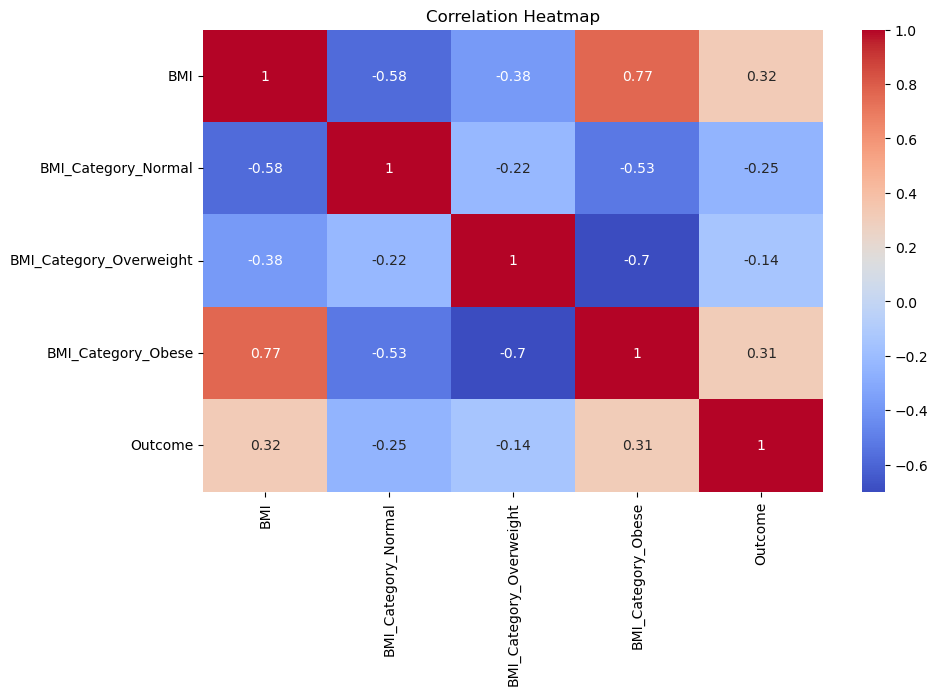

In [11]:
# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(train_with_cat[['BMI', 'BMI_Category_Normal', 'BMI_Category_Overweight', 'BMI_Category_Obese', 'Outcome']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

<b>In the continous data:</b> The correlation between continuous BMI and diabetes outcome is 0.3165, indicating a moderate positive relationship. This means that as BMI increases, there's a tendency for the likelihood of diabetes to increase as well. This aligns with our understanding of obesity as a risk factor for diabetes.

<b>In the categorised data:</b> Underweight (-0.054940): Very weak negative correlation, this could be due to the very small sample size in this category (only 0.54% of our data). The weak correlation suggests being underweight doesn't strongly predict either having or not having diabetes in our dataset; Normal (-0.249736), moderate negative correlation. This suggests that being in the normal BMI range is associated with a lower likelihood of having diabetes; Overweight (-0.143016), weak negative correlation.
While still negative, the correlation is weaker than for the Normal category. This suggests that being overweight is still associated with a lower diabetes risk compared to the reference category (likely Obese), but not as protective as being in the normal range; Obese (0.312568), moderate positive correlation. This is the strongest correlation among the categories and is very close to the correlation of continuous BMI, it indicates that being in the Obese category is associated with a higher likelihood of having diabetes.

In [12]:
X_with_cat = train_with_cat.drop(columns=['Outcome', 'BMI'])
scaler = StandardScaler()
X_with_cat_scaled = scaler.fit_transform(X_with_cat)

X_train_with_cat, X_test_with_cat, y_train, y_test = train_test_split(X_with_cat_scaled, y, stratify=y, random_state=42)

# KNN Model with BMI Categorization
knn_with_cat = KNN(n_neighbors=5)
knn_with_cat.fit(X_train_with_cat, y_train)

print("KNN Model (with BMI Cat) Evaluation:")
evaluate_model(knn_with_cat, X_train_with_cat, X_test_with_cat, y_train, y_test)

KNN Model (with BMI Cat) Evaluation:
Accuracy: 0.7482014388489209
Confusion Matrix:
 [[73 16]
 [19 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81        89
           1       0.66      0.62      0.64        50

    accuracy                           0.75       139
   macro avg       0.73      0.72      0.72       139
weighted avg       0.75      0.75      0.75       139



### Analysis and Implications

1. Impact of BMI Categorization:

- The slight decrease in overall accuracy suggests that the categorical representation of BMI might not be capturing all the nuances present in the continuous BMI data.
- However, the improvement in recall for diabetic patients indicates that BMI categories might be helping in identifying some diabetic cases that were previously missed.


2. Trade-offs in Performance:

- We've seen a trade-off between better identification of diabetic cases (higher recall for class 1) and slightly worse overall accuracy.
This trade-off might be acceptable in a medical context where identifying potential diabetic cases for further testing is crucial.


3. Class Imbalance:

- The model still shows better performance on the majority class (non-diabetic), indicating that class imbalance remains an issue.


4. Feature Importance:

- The change in performance suggests that BMI categories are providing some useful information, but perhaps not in the most optimal way.
We might need to explore how BMI categories interact with other features.


### Trying XGboost

In [13]:
feature_names = X.columns.tolist()
xgb_no_cat = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)
xgb_no_cat.fit(X_train, y_train)

print("\nXGBoost Model Evaluation:")
evaluate_model(xgb_no_cat, X_train, X_test, y_train, y_test)


XGBoost Model Evaluation:
Accuracy: 0.7266187050359713
Confusion Matrix:
 [[72 17]
 [21 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        89
           1       0.63      0.58      0.60        50

    accuracy                           0.73       139
   macro avg       0.70      0.69      0.70       139
weighted avg       0.72      0.73      0.72       139



In [14]:
feature_names_cat = X_with_cat.columns.tolist()

xgb_with_cat = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)
xgb_with_cat.fit(X_train_with_cat, y_train)

print("\nXGBoost Model Evaluation:")
evaluate_model(xgb_with_cat, X_train_with_cat, X_test_with_cat, y_train, y_test)


XGBoost Model Evaluation:
Accuracy: 0.7194244604316546
Confusion Matrix:
 [[72 17]
 [22 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        89
           1       0.62      0.56      0.59        50

    accuracy                           0.72       139
   macro avg       0.69      0.68      0.69       139
weighted avg       0.71      0.72      0.72       139



In [15]:
def evaluate_model_further(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc_roc': roc_auc_score(y_test, y_pred_proba)
    }

print("KNN without BMI categories:", evaluate_model_further(knn, X_test, y_test))
print("KNN with BMI categories:", evaluate_model_further(knn_with_cat, X_test_with_cat, y_test))
print("XGBoost without BMI categories:", evaluate_model_further(xgb_no_cat, X_test, y_test))
print("XGBoost with BMI categories:", evaluate_model_further(xgb_with_cat, X_test_with_cat, y_test))

KNN without BMI categories: {'accuracy': 0.762589928057554, 'precision': 0.6976744186046512, 'recall': 0.6, 'f1': 0.6451612903225806, 'auc_roc': 0.7944943820224719}
KNN with BMI categories: {'accuracy': 0.7482014388489209, 'precision': 0.6595744680851063, 'recall': 0.62, 'f1': 0.6391752577319586, 'auc_roc': 0.8031460674157302}
XGBoost without BMI categories: {'accuracy': 0.7266187050359713, 'precision': 0.6304347826086957, 'recall': 0.58, 'f1': 0.6041666666666666, 'auc_roc': 0.8069662921348315}
XGBoost with BMI categories: {'accuracy': 0.7194244604316546, 'precision': 0.6222222222222222, 'recall': 0.56, 'f1': 0.5894736842105264, 'auc_roc': 0.7860674157303371}


Summary:
- KNN outperforms XGBoost in overall accuracy (KNN: ~75-76%, XGBoost: ~72-73%).
- Continuous BMI slightly outperforms BMI categorization for both models.
- All models struggle with class imbalance, performing better on non-diabetic cases.
- XGBoost is more sensitive to feature representation changes than KNN.

#### XGBoost Tuning with Continuous BMI
Let's use GridSearchCV to tune XGBoost hyperparameters:

In [26]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nBest XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
feature_importance = best_model.feature_importances_
for feature, importance in zip(feature_names, feature_importance):
    print(f"{feature}: {importance}")

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}
Best cross-validation score: 0.792418454305025

Best XGBoost Model Evaluation:
Accuracy: 0.7913669064748201
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84        89
           1       0.73      0.66      0.69        50

    accuracy                           0.79       139
   macro avg       0.78      0.76      0.77       139
weighted avg       0.79      0.79      0.79       139

Pregnancies: 0.05623839795589447
Glucose: 0.2662803530693054
BloodPressure: 0.06993421912193298
SkinThickness: 0.07351898401975632
Insulin: 0.09157311916351318
BMI: 0.15397536754608154
DiabetesPedigreeFunction: 0.07526373118162155
Age: 0.1319810003042221
Insulin_Measured: 0.08123479038476944
Insulin_Log: 0.0


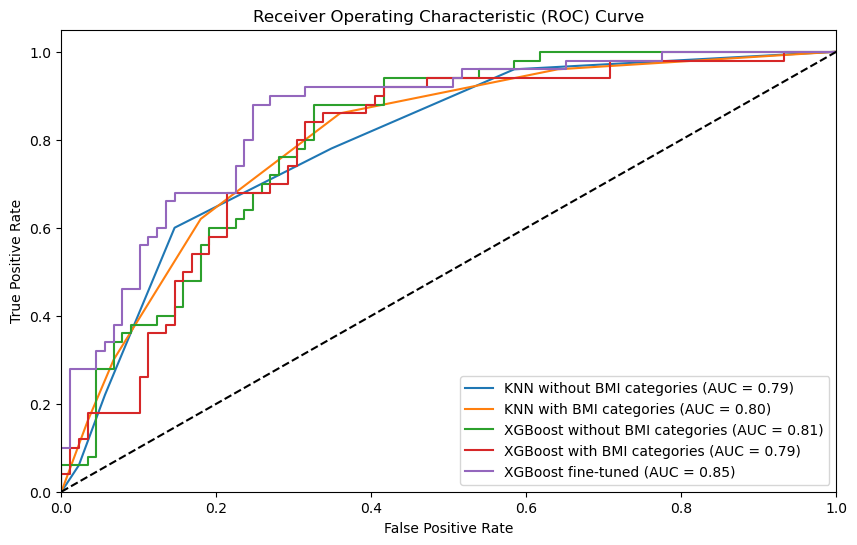

In [28]:
def plot_roc_curve(model, X_test, y_test, label):
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        # If predict_proba is not available, use decision_function
        y_pred_proba = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Now let's plot the ROC curves
plt.figure(figsize=(10, 6))

# Make sure all these models and datasets are defined
plot_roc_curve(knn, X_test, y_test, 'KNN without BMI categories')
plot_roc_curve(knn_with_cat, X_test_with_cat, y_test, 'KNN with BMI categories')
plot_roc_curve(xgb_no_cat, X_test, y_test, 'XGBoost without BMI categories')
plot_roc_curve(xgb_with_cat, X_test_with_cat, y_test, 'XGBoost with BMI categories')
plot_roc_curve(best_model, X_test, y_test, 'XGBoost fine-tuned')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Exploring Glucose Interactions

I should have done this before, but it is also important to check for interactions between the variables, lets take a look for interactions of other variables and glicose.

In [29]:
X_interactions = X.copy()

# Create interaction features
X_interactions['Glucose_BMI'] = X['Glucose'] * X['BMI']
X_interactions['Glucose_Age'] = X['Glucose'] * X['Age']
X_interactions['Glucose_Insulin'] = X['Glucose'] * X['Insulin']

# You can also create normalized versions of these interactions
X_interactions['Glucose_BMI_norm'] = X_interactions['Glucose_BMI'] / (X['Glucose'].mean() * X['BMI'].mean())
X_interactions['Glucose_Age_norm'] = X_interactions['Glucose_Age'] / (X['Glucose'].mean() * X['Age'].mean())
X_interactions['Glucose_Insulin_norm'] = X_interactions['Glucose_Insulin'] / (X['Glucose'].mean() * X['Insulin'].mean())

X_interactions.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Insulin_Measured,Insulin_Log,Glucose_BMI,Glucose_Age,Glucose_Insulin,Glucose_BMI_norm,Glucose_Age_norm,Glucose_Insulin_norm
0,6,148,72,35,125,33.6,0.627,50,0,4.836282,4972.8,7400,18500,1.256923,1.784652,1.094610
1,1,85,66,29,125,26.6,0.351,31,0,4.836282,2261.0,2635,10625,0.571490,0.635481,0.628661
2,1,89,66,23,94,28.1,0.167,21,1,4.553877,2500.9,1869,8366,0.632127,0.450745,0.495001
3,0,137,40,35,168,43.1,2.288,33,1,5.129899,5904.7,4521,23016,1.492470,1.090326,1.361814
4,5,116,74,30,125,25.6,0.201,30,0,4.836282,2969.6,3480,14500,0.750595,0.839269,0.857938


In [30]:
# Split the data
X_train_int, X_test_int, y_train, y_test = train_test_split(X_interactions, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model_int = xgb.XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=0,
    subsample=1.0,
    random_state=42
)

xgb_model_int.fit(X_train_int, y_train)

# Make predictions
y_pred = xgb_model_int.predict(X_test_int)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = xgb_model_int.feature_importances_
for feature, importance in zip(X_interactions.columns, feature_importance):
    print(f"{feature}: {importance}")

Accuracy: 0.7837837837837838

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        70
           1       0.77      0.59      0.67        41

    accuracy                           0.78       111
   macro avg       0.78      0.74      0.75       111
weighted avg       0.78      0.78      0.78       111

Pregnancies: 0.067046158015728
Glucose: 0.06422705948352814
BloodPressure: 0.04902106150984764
SkinThickness: 0.03240050747990608
Insulin: 0.039602573961019516
BMI: 0.055630333721637726
DiabetesPedigreeFunction: 0.04806873947381973
Age: 0.07400000840425491
Insulin_Measured: 0.0657161995768547
Insulin_Log: 0.0
Glucose_BMI: 0.20711089670658112
Glucose_Age: 0.18929332494735718
Glucose_Insulin: 0.10788315534591675
Glucose_BMI_norm: 0.0
Glucose_Age_norm: 0.0
Glucose_Insulin_norm: 0.0


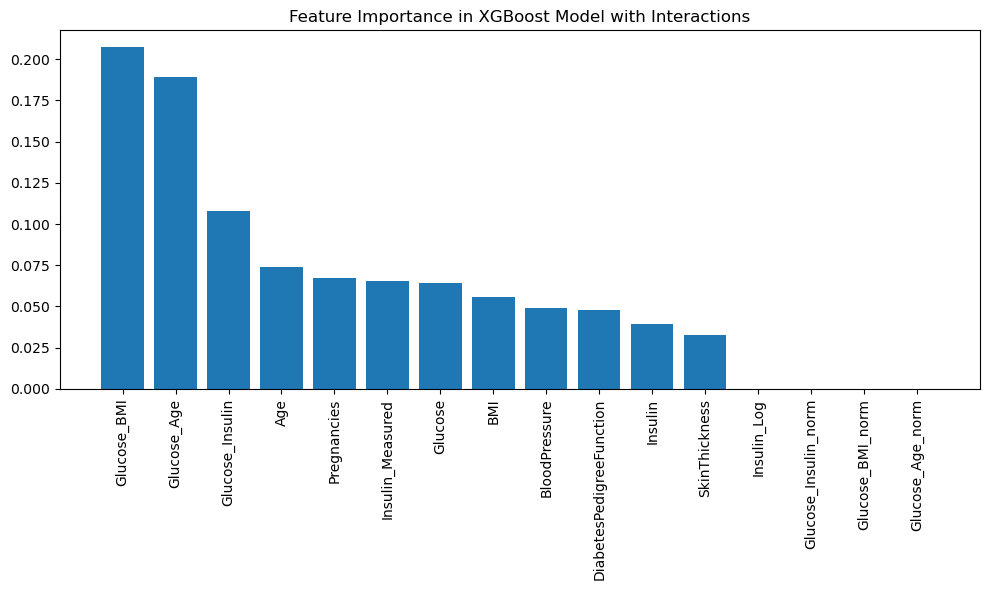

In [31]:
feature_importance = sorted(zip(feature_importance, X_interactions.columns), reverse=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), [imp for imp, _ in feature_importance])
plt.xticks(range(len(feature_importance)), [name for _, name in feature_importance], rotation=90)
plt.title('Feature Importance in XGBoost Model with Interactions')
plt.tight_layout()
plt.show()

#### Moving on...
Great, lets select the top features based on our previous analysis and create a new model:

In [36]:
top_features = [
    'Glucose_BMI', 'Glucose_Age', 'Glucose_Insulin', 
    'Age', 'Pregnancies', 'Glucose', 'Insulin_Measured',
    'BMI', 'DiabetesPedigreeFunction', 'BloodPressure'
]

# Create a new dataset with selected features
X_selected = X_interactions[top_features]

# Split the data
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Now re-train the model:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Create XGBoost classifier
xgb_model_selected = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model_selected, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_selected, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model_selected = grid_search.best_estimator_
y_pred = best_model_selected.predict(X_test_selected)
print("\nBest XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance of the best model
feature_importance = best_model_selected.feature_importances_
for feature, importance in zip(top_features, feature_importance):
    print(f"{feature}: {importance}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.8}
Best cross-validation score: 0.7915730337078651

Best XGBoost Model Evaluation:
Accuracy: 0.7747747747747747
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83        70
           1       0.74      0.61      0.67        41

    accuracy                           0.77       111
   macro avg       0.76      0.74      0.75       111
weighted avg       0.77      0.77      0.77       111

Glucose_BMI: 0.19983409345149994
Glucose_Age: 0.17608268558979034
Glucose_Insulin: 0.12747512757778168
Age: 0.06292105466127396
Pregnancies: 0.07011842727661133
Glucose: 0.07966095954179764
Insulin_Measured: 0.07255136966705322
BMI: 0.08217460662126541
DiabetesPedigreeFunction: 0.06537181884050369
BloodPressure: 0.06380989402532578
